# MNIST Classifier

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.tensorboard import SummaryWriter


import warnings
warnings.filterwarnings("ignore")

## Loading Data

- autorii SimpleNet au folosit un split de 60000 train si 10000 eval

In [7]:
# # Define data transformations if needed
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# # Load the dataset with the standard split
# # train = MNIST(root='./data', train=True, transform=transform, download=True)
# # test = MNIST(root='./data', train=False, transform=transform, download=True)

In [8]:
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('SimpleNet_Pytorch/MNIST/data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('SimpleNet_Pytorch/MNIST/data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

## Faza 2

[GitHub Repo](https://github.com/Coderx7/SimpleNet_Pytorch/blob/master/cifar/models/simplenet.py) for simplenet310k - cel folosit pt MNIST

In procesul de evaluare, in setul de test, de salvat imaginile care au fost prezise incorect de catre model, cu tuple: `idx`, `clasa prezisa`, `clasa adevarata`. 
De salvat imaginile intr-un director separat format de genul: `"im14_0_9"`.

> ! Split-ul in train,val,test este standardizat?



In [11]:
import sys

# Add the directory to the Python path in this notebook 
sys.path.append('/home/iustin/SimpleNet_Pytorch/MNIST')

from models.simplenet import simplenet_cifar_310k

In [17]:
import os 
os.getcwd()

'/home/iustin'

In [13]:
import models
# from torch.utils.tensorboard import SummaryWriter

model_names = sorted(name for name in models.__dict__
  if name.islower() and not name.startswith("__")
  and callable(models.__dict__[name]))

print('models : ',model_names)

models :  ['simplenet_cifar_310k', 'simplenet_cifar_460k', 'simplenet_cifar_5m', 'simplenet_cifar_5m_extra_pool']


In [18]:
net = models.__dict__['simplenet_cifar_310k'](num_classes=10)

In [21]:
from torchinfo import summary

summary(net, 
        input_size=(1, 1, 28, 28), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleNet (SimpleNet)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (features)                  [1, 1, 28, 28]       [1, 64, 1, 1]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 64, 28, 28]      640                  True
│    └─BatchNorm2d (1)                   [1, 64, 28, 28]      [1, 64, 28, 28]      128                  True
│    └─ReLU (2)                          [1, 64, 28, 28]      [1, 64, 28, 28]      --                   --
│    └─Dropout2d (3)                     [1, 64, 28, 28]      [1, 64, 28, 28]      --                   --
│    └─Conv2d (4)                        [1, 64, 28, 28]      [1, 32, 28, 28]      18,464               True
│    └─BatchNorm2d (5)                   [1, 32, 28, 28]      [1, 32, 28, 28]      64                   True
│    └─ReLU (6)   

In [20]:
LEARNING_RATE = 0.1
MOMENTUM = 0.9 # default 
WEIGHT_DECAY = 0 # 0.005 
NUM_EPOCH = 150
EVAL_STEP = 1
MILESTONES = [100, 190, 306, 390, 440, 540] 

STEP_SIZE= 20 # intre 10 si 100 la scheduler step_lr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

net = net.to(device)

criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adadelta(net.parameters(), lr=LEARNING_RATE, rho=0.9, eps=1e-3, # momentum=state['momentum'], # default eps = 1e-6 
                                    #  weight_decay=0.001)

optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY) 
# optimizer = torch.optim.Adam(net.parameters(),lr=LEARNING_RATE,betas=(0.9,0.999),eps=1e-08,weight_decay=0)

# scheduler = lr_scheduler.MultiStepLR(optimizer, MILESTONES, gamma=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.1)

In [ ]:
#Break
# abcd 

In [29]:
def train(net, device, train_loader, criterion, optimizer, train_loss_collector):
     for epoch in range(NUM_EPOCH):
        net.train()
        correct = 0
        epoch_loss = list()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            pred = torch.max(output.data, 1)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss_collector.append(np.round(np.mean(epoch_loss),5))
        print(f'Epoch: {epoch}/{NUM_EPOCH} \t Loss: {np.round(np.mean(epoch_loss),5)}')
        print(f'Train Accuracy: {(100. * correct / len(train_loader.dataset)):.3f}%')
        if epoch % EVAL_STEP == 0:
            evaluation(net, device, test_loader, criterion, test_loss_collector)

In [30]:
def evaluation(net, device, test_loader, criterion, test_loss_collector):
    net.eval() 
    # test_loss = 0
    correct_test = 0
    test_loss = list()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            loss = criterion(output, target)
            test_loss.append(loss.item())
            preds = output.argmax(dim=1, keepdim=True)
            correct_test += preds.eq(target.view_as(preds)).sum().item()
            test_loss_collector.append(loss.item())
        print(f'Test loss: {np.round(np.mean(test_loss), 5)} Test Accuracy: {correct_test}/{len(test_loader.dataset)}'
              f' - {(100. * correct_test / len(test_loader.dataset)):.3f}%')
    all_preds.extend(preds)
    all_targets.extend(target)

train1 difera de train. am adaugat train_accuracy_collector in train 

In [32]:
def train1(net, device, train_loader, criterion, optimizer, train_loss_collector, train_accuracy_collector):
     for epoch in range(NUM_EPOCH):
        net.train()
        correct = 0
        epoch_loss = list()
        accuracy = list() 
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            pred = torch.max(output.data, 1)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy.append(correct)
        train_loss_collector.append(np.round(np.mean(epoch_loss),5))
        train_accuracy_collector.append(np.round(np.mean(accuracy),5))
        print(f'Epoch: {epoch}/{NUM_EPOCH} \t Loss: {np.round(np.mean(epoch_loss),5)}')
        print(f'Train Accuracy: {(100. * correct / len(train_loader.dataset)):.3f}%')
        if epoch % EVAL_STEP == 0:
            evaluation(net, device, test_loader, criterion, test_loss_collector)

In [33]:
train_loss_collector = list()
train_accuracy_collector = list()
test_loss_collector = list()
all_preds = list()
all_targets = list()
print('Start training...')
train1(net, device, train_loader, criterion, optimizer, train_loss_collector, train_accuracy_collector)
print('Finish training!')

Start training...
Epoch: 0/150 	 Loss: 0.0037
Train Accuracy: 99.888%
Test loss: 0.0295 Test Accuracy: 9932/10000 - 99.320%
Epoch: 1/150 	 Loss: 0.0029
Train Accuracy: 99.910%
Test loss: 0.02791 Test Accuracy: 9936/10000 - 99.360%
Epoch: 2/150 	 Loss: 0.00341
Train Accuracy: 99.907%
Test loss: 0.03359 Test Accuracy: 9913/10000 - 99.130%
Epoch: 3/150 	 Loss: 0.00269
Train Accuracy: 99.900%
Test loss: 0.02291 Test Accuracy: 9939/10000 - 99.390%
Epoch: 4/150 	 Loss: 0.00198
Train Accuracy: 99.947%
Test loss: 0.02115 Test Accuracy: 9943/10000 - 99.430%
Epoch: 5/150 	 Loss: 0.00092
Train Accuracy: 99.972%
Test loss: 0.01839 Test Accuracy: 9953/10000 - 99.530%
Epoch: 6/150 	 Loss: 0.00056
Train Accuracy: 99.982%
Test loss: 0.0415 Test Accuracy: 9909/10000 - 99.090%
Epoch: 7/150 	 Loss: 0.00112
Train Accuracy: 99.970%
Test loss: 0.02409 Test Accuracy: 9948/10000 - 99.480%
Epoch: 8/150 	 Loss: 0.00149
Train Accuracy: 99.947%
Test loss: 0.02981 Test Accuracy: 9941/10000 - 99.410%
Epoch: 9/150 	

In [ ]:
# train_loss_collector
# test_loss_collector

ValueError: All arrays must be of the same length

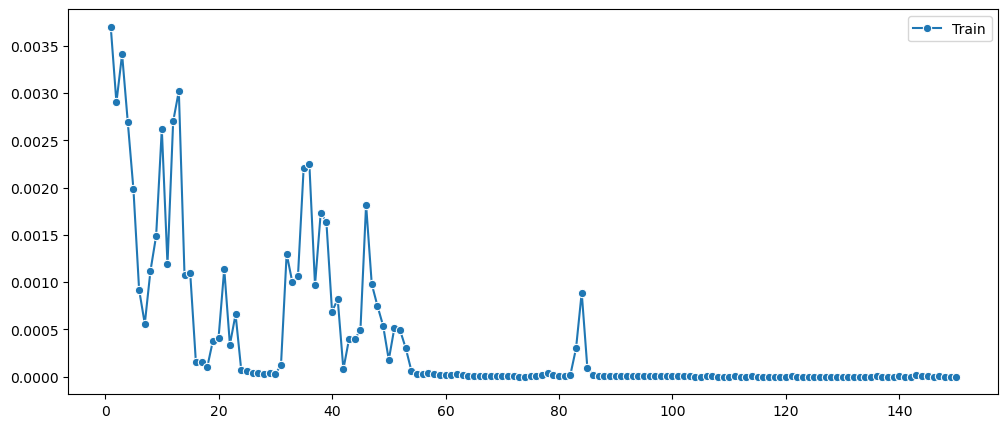

In [34]:
plt.figure(figsize=(12,5))
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=train_loss_collector, label='Train', marker='o')
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=test_loss_collector, label='Eval', marker='o')
plt.title('Loss for train and eval')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show();

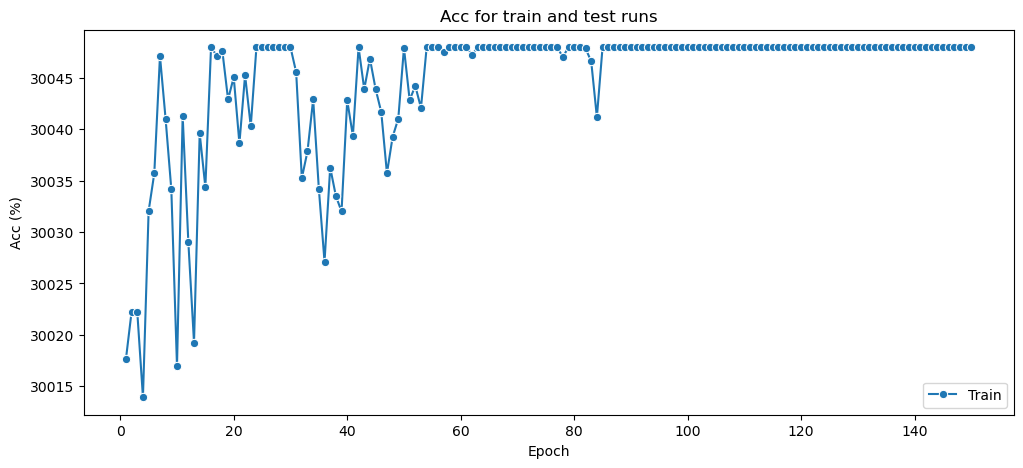

In [35]:
plt.figure(figsize=(12,5))
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=train_accuracy_collector, label='Train', marker='o')
# sns.lineplot(x=range(1, NUM_EPOCH + 1), y=test_loss_collector, label='Test', marker='o')
plt.title('Acc for train and test runs')
plt.ylabel('Acc (%)')
plt.xlabel('Epoch')
plt.show();

## De facut

1. De modificat training and eval loop: de adaugat liste de `train_accuracy si test_accuracy` pentru plotare
2. De optimizat hyperparameters pentru a atinge cifrele autorilor, din `main.py`, de adaugat lr scheduler. 
3. De adaugat `test_loss collector` in bucla de evaluare pentru a vizualiza.
4. De salvat in checkpoint-uri modelul. 

5. De salvat model_state_dict in 2 checkpoint-uri (): 
        1. best loss - o variabila care sa contina loss-ul pentru validare (in test_loss_collector)
        2. best acc - o variabila care sa contina accuracy-ul pe setul de validare (test_acc_collector) 

> ! de salvat epoch, seed-ul si alte informatii care permit reproductibilitatea 

> de salvat tabela in care sa afisez loss-ul si accuracy-ul in dataframe (epoch, train_acc, test_acc, train_loss, test_loss)

> de salvat hyperparametrii in checkpoint 

> de salvat pentru toate epocile
 
